In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits, make_blobs , make_moons, make_circles , make_swiss_roll
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE , trustworthiness
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist
import time
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("tab10")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
def tsne_parameter_analysis(X, perplexity_range=None, learning_rate_range=None, n_iter=1000, random_state=42):
    """
    Analyze t-SNE performance across different parameter combinations.
    
    Parameters:
    -----------
    X : array-like
        Input data
    perplexity_range : list, optional
        Range of perplexity values to test
    learning_rate_range : list, optional
        Range of learning rates to test
    n_iter : int, default=1000
        Number of iterations for each t-SNE run
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    pd.DataFrame : Results of parameter analysis
    """
    if perplexity_range is None:
        perplexity_range = [5, 15, 30, 50, 100]
    if learning_rate_range is None:
        learning_rate_range = [10, 50, 200, 500, 1000]
    
    results = []
    
    print("🔍 Running t-SNE parameter analysis...")
    print(f"📊 Testing {len(perplexity_range)} perplexity × {len(learning_rate_range)} learning rate combinations")
    
    for perplexity in perplexity_range:
        # Skip if perplexity is too large for dataset
        if perplexity >= len(X) / 3:
            continue
            
        for lr in learning_rate_range:
            print(f"   Testing: perplexity={perplexity}, learning_rate={lr}")
            
            start_time = time.time()
            
            # Run t-SNE
            tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, n_iter=n_iter, random_state=random_state, verbose=0)
            
            try:
                embedding = tsne.fit_transform(X)
                runtime = time.time() - start_time
                
                # Calculate quality metrics
                # 1. KL divergence (lower is better)
                kl_divergence = tsne.kl_divergence_
                
                # 2. Local structure preservation (using nearest neighbors)
                nn_original = NearestNeighbors(n_neighbors=min(10, len(X)//4))
                nn_original.fit(X)
                nn_embedded = NearestNeighbors(n_neighbors=min(10, len(X)//4))
                nn_embedded.fit(embedding)
                
                # Sample points for efficiency
                sample_size = min(100, len(X))
                sample_indices = np.random.choice(len(X), sample_size, replace=False)
                
                preservation_scores = []
                for idx in sample_indices:
                    # Get neighbors in original space
                    orig_neighbors = nn_original.kneighbors([X[idx]], return_distance=False)[0]
                    # Get neighbors in embedded space
                    embed_neighbors = nn_embedded.kneighbors([embedding[idx]], return_distance=False)[0]
                    # Calculate overlap
                    overlap = len(set(orig_neighbors) & set(embed_neighbors)) / len(orig_neighbors)
                    preservation_scores.append(overlap)
                
                neighborhood_preservation = np.mean(preservation_scores)
                
                results.append({
                    'perplexity': perplexity,
                    'learning_rate': lr,
                    'kl_divergence': kl_divergence,
                    'neighborhood_preservation': neighborhood_preservation,
                    'runtime_seconds': runtime,
                    'converged': True
                })
                
            except Exception as e:
                print(f"   ❌ Failed: {str(e)}")
                results.append({
                    'perplexity': perplexity,
                    'learning_rate': lr,
                    'kl_divergence': np.inf,
                    'neighborhood_preservation': 0.0,
                    'runtime_seconds': np.inf,
                    'converged': False
                })
    
    return pd.DataFrame(results)

def plot_tsne_comparison(X, y=None, perplexity_values=[5, 30, 100], 
                        feature_names=None, class_names=None, figsize=(20, 12)):
    """
    Compare t-SNE results with different perplexity values.
    
    Parameters:
    -----------
    X : array-like
        Input data
    y : array-like, optional
        True labels for coloring
    perplexity_values : list, default=[5, 30, 100]
        Perplexity values to compare
    feature_names : list, optional
        Names of original features
    class_names : list, optional
        Names of classes/labels
    figsize : tuple, default=(20, 12)
        Figure size
    """
    n_plots = len(perplexity_values) + 1  # +1 for PCA comparison
    fig, axes = plt.subplots(2, (n_plots + 1) // 2, figsize=figsize)
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    # First plot: PCA for comparison
    print("📊 Computing PCA for comparison...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    
    scatter = axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='tab10', alpha=0.7, s=60)
    axes[0].set_title(f'PCA (Linear)\nExplained Variance: {pca.explained_variance_ratio_.sum():.1%}', fontweight='bold', fontsize=12)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    axes[0].grid(alpha=0.3)
    
    # t-SNE plots with different perplexities
    for i, perplexity in enumerate(perplexity_values):
        if perplexity >= len(X) / 3:
            print(f"⚠️ Skipping perplexity {perplexity} (too large for dataset size)")
            continue
            
        print(f"🎨 Computing t-SNE with perplexity={perplexity}...")
        
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, n_iter=2000, random_state=42)
        tsne_result = tsne.fit_transform(X)
        
        scatter = axes[i+1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=y, cmap='tab10', alpha=0.7, s=60)
        axes[i+1].set_title(f't-SNE (perplexity={perplexity})\nKL divergence: {tsne.kl_divergence_:.2f}', fontweight='bold', fontsize=12)
        axes[i+1].set_xlabel('t-SNE 1')
        axes[i+1].set_ylabel('t-SNE 2')
        axes[i+1].grid(alpha=0.3)
    
    # Add colorbar if labels provided
    if y is not None:
        plt.colorbar(scatter, ax=axes, label='Class')
    
    # Hide empty subplots
    for j in range(len(perplexity_values) + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def evaluate_tsne_quality(X_original, X_embedded, k=10):
    """
    Evaluate t-SNE embedding quality using various metrics.
    
    Parameters:
    -----------
    X_original : array-like
        Original high-dimensional data
    X_embedded : array-like
        t-SNE embedded data
    k : int, default=10
        Number of neighbors for local structure evaluation
    
    Returns:
    --------
    dict : Quality metrics
    """
    
    n_samples = len(X_original)
    k = min(k, n_samples - 1)
    
    # 1. Neighborhood preservation
    nn_orig = NearestNeighbors(n_neighbors=k+1)  # +1 because first neighbor is the point itself
    nn_orig.fit(X_original)
    orig_neighbors = nn_orig.kneighbors(return_distance=False)[:, 1:]  # Exclude self
    
    nn_embed = NearestNeighbors(n_neighbors=k+1)
    nn_embed.fit(X_embedded)
    embed_neighbors = nn_embed.kneighbors(return_distance=False)[:, 1:]  # Exclude self
    
    preservation_scores = []
    for i in range(n_samples):
        overlap = len(set(orig_neighbors[i]) & set(embed_neighbors[i])) / k
        preservation_scores.append(overlap)
    
    neighborhood_preservation = np.mean(preservation_scores)
    
    # 2. Distance correlation (sample for efficiency on large datasets)
    sample_size = min(500, n_samples)
    sample_indices = np.random.choice(n_samples, sample_size, replace=False)
    
    X_orig_sample = X_original[sample_indices]
    X_embed_sample = X_embedded[sample_indices]
    
    orig_distances = pdist(X_orig_sample)
    embed_distances = pdist(X_embed_sample)
    
    distance_correlation, _ = spearmanr(orig_distances, embed_distances)
    
    # 3. Trustworthiness and Continuity
    def trustworthiness(X_orig, X_embed, k):
        """Calculate trustworthiness metric."""
        nn_orig = NearestNeighbors(n_neighbors=k+1).fit(X_orig)
        nn_embed = NearestNeighbors(n_neighbors=k+1).fit(X_embed)
        
        trust_sum = 0
        for i in range(len(X_orig)):
            # k-nearest neighbors in embedded space
            embed_neighbors = nn_embed.kneighbors([X_embed[i]], return_distance=False)[0][1:]
            
            # Ranks of these neighbors in original space
            orig_distances = nn_orig.kneighbors([X_orig[i]], n_neighbors=len(X_orig), return_distance=False)[0][1:]
            orig_ranks = {point: rank for rank, point in enumerate(orig_distances)}
            
            for neighbor in embed_neighbors:
                if neighbor in orig_ranks and orig_ranks[neighbor] >= k:
                    trust_sum += orig_ranks[neighbor] - k
        
        max_trust = k * len(X_orig) * (2 * len(X_orig) - 3 * k - 1) / 2
        return 1 - (2 * trust_sum) / max_trust if max_trust > 0 else 1
    
    # Calculate on sample for efficiency
    trustworthiness_score = trustworthiness(X_orig_sample, X_embed_sample, min(k, len(X_orig_sample)-1))
    
    return {
        'neighborhood_preservation': neighborhood_preservation,
        'distance_correlation': distance_correlation,
        'trustworthiness': trustworthiness_score,
        'sample_size_used': sample_size
    }

print("✅ t-SNE analysis functions defined successfully!")
print("🎨 Ready for comprehensive visualization analysis")

✅ t-SNE analysis functions defined successfully!
🎨 Ready for comprehensive visualization analysis


In [3]:
# Data Generation and Preparation
def create_sample_datasets():
    """Create various sample datasets for t-SNE demonstration"""
    # Dataset 1: Swiss roll
    n_samples = 1000
    swiss_roll, swiss_colors = make_swiss_roll(n_samples=n_samples, noise=0.2, random_state=42)
    
    # Dataset 2: Blobs
    blob_data, blob_labels = make_blobs(n_samples=n_samples, centers=4, n_features=10, 
                                        cluster_std=1.5, random_state=42)
    
    # Dataset 3: Circles
    circle_data, circle_labels = make_circles(n_samples=n_samples, noise=0.1, factor=0.5, random_state=42)
    
    # Dataset 4: Moons
    moon_data, moon_labels = make_moons(n_samples=n_samples, noise=0.15, random_state=42)
    
    return {
        'swiss_roll': (swiss_roll, swiss_colors),
        'blobs': (blob_data, blob_labels),
        'circles': (circle_data, circle_labels),
        'moons': (moon_data, moon_labels)
    }

# Parameter optimization function
def optimize_tsne_parameters(X, param_grid=None, sample_size=500):
    """
    Optimize t-SNE parameters using silhouette score
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input data
    param_grid : dict
        Parameter grid for optimization
    sample_size : int
        Sample size for faster optimization
    
    Returns:
    --------
    best_params : dict
        Best parameters found
    results : list
        All parameter combinations and scores
    """
    if param_grid is None:
        param_grid = {
            'perplexity': [5, 10, 30, 50],
            'learning_rate': [10, 50, 100, 200],
            'n_iter': [500, 1000]
        }
    
    # Sample data for faster optimization
    if len(X) > sample_size:
        idx = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X
    
    results = []
    best_score = -1
    best_params = None
    
    print("Optimizing t-SNE parameters...")
    print("Parameter combinations to test:", 
          len(param_grid['perplexity']) * len(param_grid['learning_rate']) * len(param_grid['n_iter']))
    
    for perplexity in param_grid['perplexity']:
        for learning_rate in param_grid['learning_rate']:
            for n_iter in param_grid['n_iter']:
                try:
                    # Apply t-SNE
                    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42, verbose=0)
                    X_embedded = tsne.fit_transform(X_sample)
                    
                    # Calculate silhouette score (using KMeans clustering)
                    kmeans = KMeans(n_clusters=min(8, len(np.unique(X_sample, axis=0))), random_state=42, n_init=10)
                    cluster_labels = kmeans.fit_predict(X_embedded)
                    
                    if len(np.unique(cluster_labels)) > 1:
                        score = silhouette_score(X_embedded, cluster_labels)
                    else:
                        score = -1
                    
                    results.append({
                        'perplexity': perplexity,
                        'learning_rate': learning_rate,
                        'n_iter': n_iter,
                        'silhouette_score': score,
                        'kl_divergence': tsne.kl_divergence_
                    })
                    
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'perplexity': perplexity,
                            'learning_rate': learning_rate,
                            'n_iter': n_iter
                        }
                    
                    print(f"Perplexity: {perplexity}, LR: {learning_rate}, Iter: {n_iter}, Score: {score:.3f}")
                    
                except Exception as e:
                    print(f"Error with params perplexity={perplexity}, lr={learning_rate}, iter={n_iter}: {e}")
                    continue
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best silhouette score: {best_score:.3f}")
    
    return best_params, results

In [4]:
# Visualization Functions
def plot_tsne_results(X_embedded, labels=None, title="t-SNE Visualization", colors=None, size=(10, 8)):
    """
    Plot t-SNE results with optional coloring by labels
    
    Parameters:
    -----------
    X_embedded : array-like, shape (n_samples, 2)
        2D t-SNE embedding
    labels : array-like, optional
        Labels for coloring points
    title : str
        Plot title
    colors : array-like, optional
        Custom colors for points
    size : tuple
        Figure size
    """
    fig, ax = plt.subplots(1, 1, figsize=size)
    
    if labels is not None:
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7, s=30)
        plt.colorbar(scatter, ax=ax)
    elif colors is not None:
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, alpha=0.7, s=30)
    else:
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.7, s=30)
    
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

def compare_embeddings(data_dict, perplexity=30, learning_rate=200):
    """
    Compare t-SNE embeddings across different datasets
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary with dataset names as keys and (X, labels) as values
    perplexity : float
        t-SNE perplexity parameter
    learning_rate : float
        t-SNE learning rate
    """
    n_datasets = len(data_dict)
    fig, axes = plt.subplots(2, n_datasets, figsize=(4*n_datasets, 8))
    if n_datasets == 1:
        axes = axes.reshape(2, 1)
    
    for i, (name, (X, labels)) in enumerate(data_dict.items()):
        # Original data (first 2 dimensions if available)
        if X.shape[1] >= 2:
            axes[0, i].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)
            axes[0, i].set_title(f'{name} - Original (2D projection)')
        else:
            axes[0, i].text(0.5, 0.5, 'Original data\n1D only', ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].set_title(f'{name} - Original')
        
        # t-SNE embedding
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42, verbose=0)
        X_embedded = tsne.fit_transform(X)
        
        axes[1, i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)
        axes[1, i].set_title(f'{name} - t-SNE\n(KL div: {tsne.kl_divergence_:.2f})')
        axes[1, i].set_xlabel('t-SNE Component 1')
        axes[1, i].set_ylabel('t-SNE Component 2')
    
    plt.tight_layout()
    return fig

# Evaluation Functions
def evaluate_embedding_quality(X_original, X_embedded, labels=None, k_neighbors=15):
    """
    Evaluate the quality of t-SNE embedding using multiple metrics
    
    Parameters:
    -----------
    X_original : array-like
        Original high-dimensional data
    X_embedded : array-like
        2D t-SNE embedding
    labels : array-like, optional
        True labels for supervised evaluation
    k_neighbors : int
        Number of neighbors for trustworthiness and continuity
    
    Returns:
    --------
    metrics : dict
        Dictionary containing various quality metrics
    """
    metrics = {}
    
    # 1. Trustworthiness and Continuity
    metrics['trustworthiness'] = trustworthiness(X_original, X_embedded, n_neighbors=k_neighbors)
    
    # 2. Neighborhood preservation (manual implementation)
    # For each point, check how many of its k nearest neighbors in original space
    # are also among its k nearest neighbors in embedded space
        
    # Original space neighbors
    nbrs_orig = NearestNeighbors(n_neighbors=k_neighbors+1).fit(X_original)
    _, indices_orig = nbrs_orig.kneighbors(X_original)
    
    # Embedded space neighbors
    nbrs_emb = NearestNeighbors(n_neighbors=k_neighbors+1).fit(X_embedded)
    _, indices_emb = nbrs_emb.kneighbors(X_embedded)
    
    # Calculate neighborhood preservation
    preservation_scores = []
    for i in range(len(X_original)):
        orig_neighbors = set(indices_orig[i][1:])  # Exclude self
        emb_neighbors = set(indices_emb[i][1:])    # Exclude self
        preserved = len(orig_neighbors.intersection(emb_neighbors))
        preservation_scores.append(preserved / k_neighbors)
    
    metrics['neighborhood_preservation'] = np.mean(preservation_scores)
    
    # 3. If labels are available, calculate clustering metrics
    if labels is not None:
        # Silhouette score on embedded data
        if len(np.unique(labels)) > 1:
            metrics['silhouette_score'] = silhouette_score(X_embedded, labels)
            metrics['calinski_harabasz'] = calinski_harabasz_score(X_embedded, labels)
            metrics['davies_bouldin'] = davies_bouldin_score(X_embedded, labels)
    
    # Calculate pairwise distances
    dist_orig = pdist(X_original)
    dist_emb = pdist(X_embedded)
    
    # Spearman correlation between distance matrices
    metrics['distance_correlation'], _ = spearmanr(dist_orig, dist_emb)
    
    return metrics

def print_evaluation_results(metrics):
    """Print evaluation metrics in a formatted way"""
    print("="*50)
    print("t-SNE EMBEDDING QUALITY EVALUATION")
    print("="*50)
    
    print(f"Trustworthiness           : {metrics.get('trustworthiness', 'N/A'):.4f}")
    print(f"Neighborhood Preservation : {metrics.get('neighborhood_preservation', 'N/A'):.4f}")
    print(f"Distance Correlation      : {metrics.get('distance_correlation', 'N/A'):.4f}")
    
    if 'silhouette_score' in metrics:
        print(f"Silhouette Score        : {metrics['silhouette_score']:.4f}")
        print(f"Calinski-Harabasz Index : {metrics['calinski_harabasz']:.4f}")
        print(f"Davies-Bouldin Index    : {metrics['davies_bouldin']:.4f}")
    
    print("="*50)
    print("INTERPRETATION GUIDE:")
    print("• Trustworthiness (0-1)      : Higher is better (>0.8 excellent)")
    print("• Neighborhood Preservation  : Higher is better (>0.7 good)")
    print("• Distance Correlation       : Higher is better (>0.6 good)")
    print("• Silhouette Score (-1 to 1) : Higher is better (>0.5 good)")
    print("="*50)

In [5]:
# Reusable t-SNE Pipeline Class
class TSNEPipeline:
    """
    A comprehensive t-SNE pipeline for dimensionality reduction and visualization
    
    This class provides a complete workflow for t-SNE analysis including:
    - Data preprocessing
    - Parameter optimization
    - Embedding generation
    - Quality evaluation
    - Visualization
    """
    
    def __init__(self, n_components=2, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.tsne = None
        self.best_params = None
        self.X_embedded = None
        self.evaluation_metrics = None
        
    def preprocess_data(self, X, scale=True, remove_duplicates=True):
        """
        Preprocess data for t-SNE analysis
        
        Parameters:
        -----------
        X : array-like
            Input data
        scale : bool
            Whether to standardize features
        remove_duplicates : bool
            Whether to remove duplicate rows
        
        Returns:
        --------
        X_processed : array-like
            Preprocessed data
        """
        X_processed = X.copy()
        
        # Remove duplicates
        if remove_duplicates:
            unique_mask = ~pd.DataFrame(X_processed).duplicated()
            X_processed = X_processed[unique_mask]
            print(f"Removed {(~unique_mask).sum()} duplicate rows")
        
        # Scale features
        if scale:
            X_processed = self.scaler.fit_transform(X_processed)
            print("Data standardized")
        
        return X_processed
    
    def optimize_parameters(self, X, param_grid=None, sample_size=500, cv_folds=3):
        """
        Optimize t-SNE parameters using cross-validation
        
        Parameters:
        -----------
        X : array-like
            Input data
        param_grid : dict
            Parameter grid for optimization
        sample_size : int
            Sample size for faster optimization
        cv_folds : int
            Number of cross-validation folds
        
        Returns:
        --------
        best_params : dict
            Optimized parameters
        """
        if param_grid is None:
            param_grid = {
                'perplexity': [5, 10, 30, 50],
                'learning_rate': [50, 100, 200, 500],
                'n_iter': [1000, 2000]
            }
        
        best_params, results = optimize_tsne_parameters(X, param_grid, sample_size)
        self.best_params = best_params
        
        # Create results DataFrame for analysis
        self.optimization_results = pd.DataFrame(results)
        
        return best_params
    
    def fit_transform(self, X, use_optimized_params=True, **tsne_kwargs):
        """
        Fit t-SNE and transform data
        
        Parameters:
        -----------
        X : array-like
            Input data
        use_optimized_params : bool
            Whether to use optimized parameters
        **tsne_kwargs : dict
            Additional t-SNE parameters
        
        Returns:
        --------
        X_embedded : array-like
            2D embedding
        """
        # Set parameters
        if use_optimized_params and self.best_params:
            params = self.best_params.copy()
            params.update(tsne_kwargs)
        else:
            params = {'perplexity': 30, 'learning_rate': 200, 'n_iter': 1000}
            params.update(tsne_kwargs)
        
        # Create and fit t-SNE
        self.tsne = TSNE(
            n_components=self.n_components,
            random_state=self.random_state,
            **params
        )
        
        print(f"Running t-SNE with parameters: {params}")
        self.X_embedded = self.tsne.fit_transform(X)
        
        print(f"t-SNE completed. KL divergence: {self.tsne.kl_divergence_:.4f}")
        
        return self.X_embedded
    
    def evaluate_quality(self, X_original, labels=None, k_neighbors=15):
        """
        Evaluate embedding quality
        
        Parameters:
        -----------
        X_original : array-like
            Original high-dimensional data
        labels : array-like, optional
            True labels
        k_neighbors : int
            Number of neighbors for evaluation
        
        Returns:
        --------
        metrics : dict
            Quality metrics
        """
        if self.X_embedded is None:
            raise ValueError("No embedding found. Run fit_transform first.")
        
        self.evaluation_metrics = evaluate_embedding_quality(X_original, self.X_embedded, labels, k_neighbors)
        
        return self.evaluation_metrics
    
    def plot_results(self, labels=None, colors=None, title="t-SNE Results", figsize=(12, 5), show_evaluation=True):
        """
        Plot t-SNE results with optional evaluation metrics
        
        Parameters:
        -----------
        labels : array-like, optional
            Labels for coloring
        colors : array-like, optional
            Custom colors
        title : str
            Plot title
        figsize : tuple
            Figure size
        show_evaluation : bool
            Whether to show evaluation metrics as text
        
        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        """
        if self.X_embedded is None:
            raise ValueError("No embedding found. Run fit_transform first.")
        
        if show_evaluation and self.evaluation_metrics:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            
            # t-SNE plot
            if labels is not None:
                scatter = ax1.scatter(self.X_embedded[:, 0], self.X_embedded[:, 1], 
                                    c=labels, cmap='tab10', alpha=0.7, s=30)
                plt.colorbar(scatter, ax=ax1)
            elif colors is not None:
                ax1.scatter(self.X_embedded[:, 0], self.X_embedded[:, 1], c=colors, alpha=0.7, s=30)
            else:
                ax1.scatter(self.X_embedded[:, 0], self.X_embedded[:, 1], alpha=0.7, s=30)
            
            ax1.set_xlabel('t-SNE Component 1')
            ax1.set_ylabel('t-SNE Component 2')
            ax1.set_title(title)
            ax1.grid(True, alpha=0.3)
            
            # Evaluation metrics
            metrics_text = "Quality Metrics:\n\n"
            for key, value in self.evaluation_metrics.items():
                if isinstance(value, float):
                    metrics_text += f"{key.replace('_', ' ').title()}: {value:.4f}\n"
            
            ax2.text(0.1, 0.9, metrics_text, transform=ax2.transAxes, 
                    verticalalignment='top', fontsize=10, 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            ax2.set_xlim(0, 1)
            ax2.set_ylim(0, 1)
            ax2.axis('off')
            ax2.set_title('Embedding Quality')
            
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(figsize[0]//2, figsize[1]))
            plot_tsne_results(self.X_embedded, labels, title, colors, figsize)
        
        plt.tight_layout()
        return fig
    
    def save_results(self, filepath, include_original=True, X_original=None):
        """
        Save t-SNE results to file
        
        Parameters:
        -----------
        filepath : str
            Path to save results
        include_original : bool
            Whether to include original data
        X_original : array-like, optional
            Original data to include
        """
        if self.X_embedded is None:
            raise ValueError("No embedding found. Run fit_transform first.")
        
        results = {
            'tsne_embedding': self.X_embedded,
            'tsne_parameters': self.best_params or {},
            'kl_divergence': self.tsne.kl_divergence_ if self.tsne else None,
            'evaluation_metrics': self.evaluation_metrics or {}
        }
        
        if include_original and X_original is not None:
            results['original_data'] = X_original
        
        np.savez(filepath, **results)
        print(f"Results saved to {filepath}")

# Demonstration with Multiple Datasets
def run_comprehensive_analysis():
    """
    Run comprehensive t-SNE analysis on multiple datasets
    """
    print("Creating sample datasets...")
    datasets = create_sample_datasets()
    
    # Initialize pipeline
    pipeline = TSNEPipeline(random_state=42)
    
    results = {}
    
    for name, (X, labels) in datasets.items():
        print(f"\n{'='*60}")
        print(f"ANALYZING DATASET: {name.upper()}")
        print(f"{'='*60}")
        print(f"Data shape: {X.shape}")
        print(f"Number of classes: {len(np.unique(labels))}")
        
        # Preprocess data
        X_processed = pipeline.preprocess_data(X, scale=True)
        
        # Optimize parameters (on a subset for speed)
        if len(X_processed) > 300:
            sample_idx = np.random.choice(len(X_processed), 300, replace=False)
            X_sample = X_processed[sample_idx]
            labels_sample = labels[sample_idx] if labels is not None else None
        else:
            X_sample = X_processed
            labels_sample = labels
        
        print("\\nOptimizing parameters...")
        best_params = pipeline.optimize_parameters(X_sample)
        
        # Fit t-SNE with optimized parameters
        print("\\nRunning t-SNE with optimized parameters...")
        X_embedded = pipeline.fit_transform(X_processed, use_optimized_params=True)
        
        # Evaluate quality
        print("\\nEvaluating embedding quality...")
        metrics = pipeline.evaluate_quality(X_processed, labels)
        print_evaluation_results(metrics)
        
        # Plot results
        pipeline.plot_results(labels=labels, title=f't-SNE: {name}', 
                            figsize=(15, 6), show_evaluation=True)
        plt.show()
        
        # Store results
        results[name] = {
            'best_params': best_params,
            'embedding': X_embedded,
            'metrics': metrics,
            'kl_divergence': pipeline.tsne.kl_divergence_
        }
    
    return results

## 🎯 **Example 1: Digits Dataset Visualization**

=== EXAMPLE 1: Quick t-SNE Analysis ===
Removed 0 duplicate rows
Data standardized
Running t-SNE with parameters: {'perplexity': 30, 'learning_rate': 200, 'n_iter': 1000}
t-SNE completed. KL divergence: 0.8260
t-SNE EMBEDDING QUALITY EVALUATION
Trustworthiness           : 0.9814
Neighborhood Preservation : 0.5678
Distance Correlation      : 0.3659
Silhouette Score        : 0.4923
Calinski-Harabasz Index : 1536.5271
Davies-Bouldin Index    : 1.2109
INTERPRETATION GUIDE:
• Trustworthiness (0-1)      : Higher is better (>0.8 excellent)
• Neighborhood Preservation  : Higher is better (>0.7 good)
• Distance Correlation       : Higher is better (>0.6 good)
• Silhouette Score (-1 to 1) : Higher is better (>0.5 good)


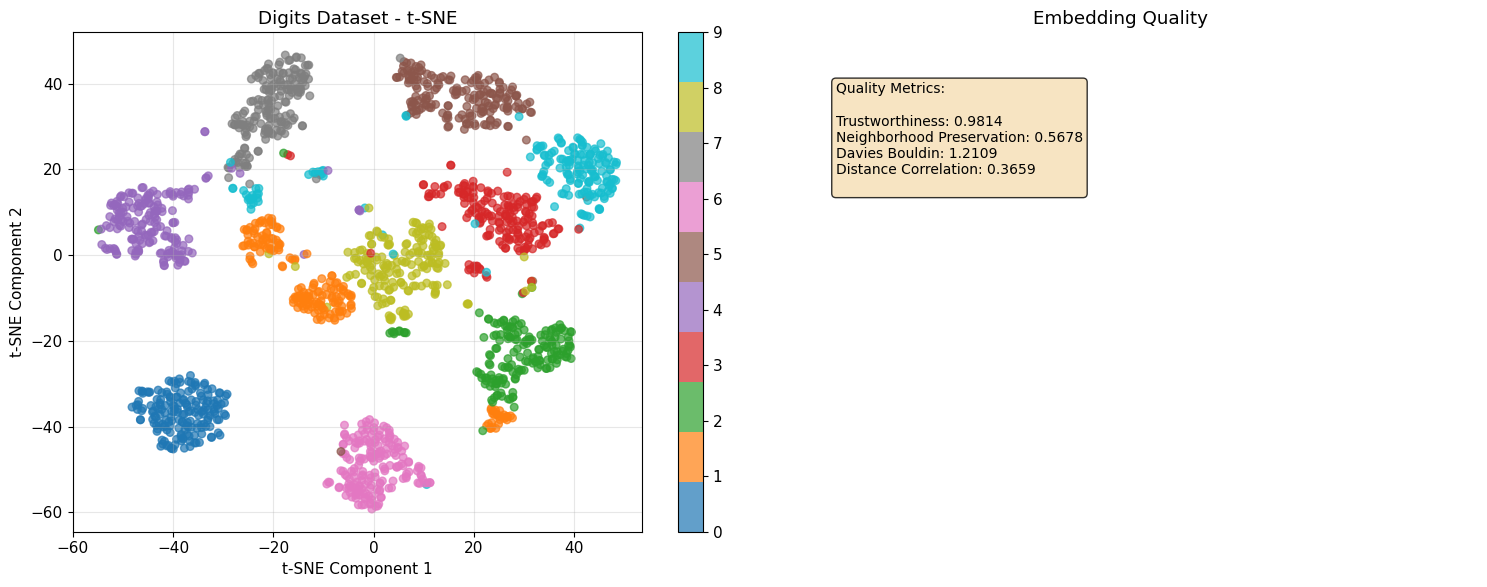

In [6]:
# Example 1: Quick Analysis
print("=== EXAMPLE 1: Quick t-SNE Analysis ===")

# Create sample data
digits = load_digits()
X, y = digits.data, digits.target

# Initialize and run pipeline
pipeline = TSNEPipeline()
X_processed = pipeline.preprocess_data(X)

# Quick run with default parameters
X_embedded = pipeline.fit_transform(X_processed, use_optimized_params=False, perplexity=30, learning_rate=200)

# Evaluate and plot
metrics = pipeline.evaluate_quality(X_processed, y)
print_evaluation_results(metrics)
pipeline.plot_results(labels=y, title='Digits Dataset - t-SNE', figsize=(15, 6))
plt.show()


=== EXAMPLE 2: Parameter Optimization ===
Optimizing t-SNE parameters...
Optimizing t-SNE parameters...
Parameter combinations to test: 32
Perplexity: 5, LR: 50, Iter: 1000, Score: 0.529
Perplexity: 5, LR: 50, Iter: 2000, Score: 0.560
Perplexity: 5, LR: 100, Iter: 1000, Score: 0.550
Perplexity: 5, LR: 100, Iter: 2000, Score: 0.578
Perplexity: 5, LR: 200, Iter: 1000, Score: 0.525
Perplexity: 5, LR: 200, Iter: 2000, Score: 0.552
Perplexity: 5, LR: 500, Iter: 1000, Score: 0.546
Perplexity: 5, LR: 500, Iter: 2000, Score: 0.586
Perplexity: 10, LR: 50, Iter: 1000, Score: 0.543
Perplexity: 10, LR: 50, Iter: 2000, Score: 0.554
Perplexity: 10, LR: 100, Iter: 1000, Score: 0.554
Perplexity: 10, LR: 100, Iter: 2000, Score: 0.558
Perplexity: 10, LR: 200, Iter: 1000, Score: 0.556
Perplexity: 10, LR: 200, Iter: 2000, Score: 0.561
Perplexity: 10, LR: 500, Iter: 1000, Score: 0.561
Perplexity: 10, LR: 500, Iter: 2000, Score: 0.565
Perplexity: 30, LR: 50, Iter: 1000, Score: 0.499
Perplexity: 30, LR: 50,

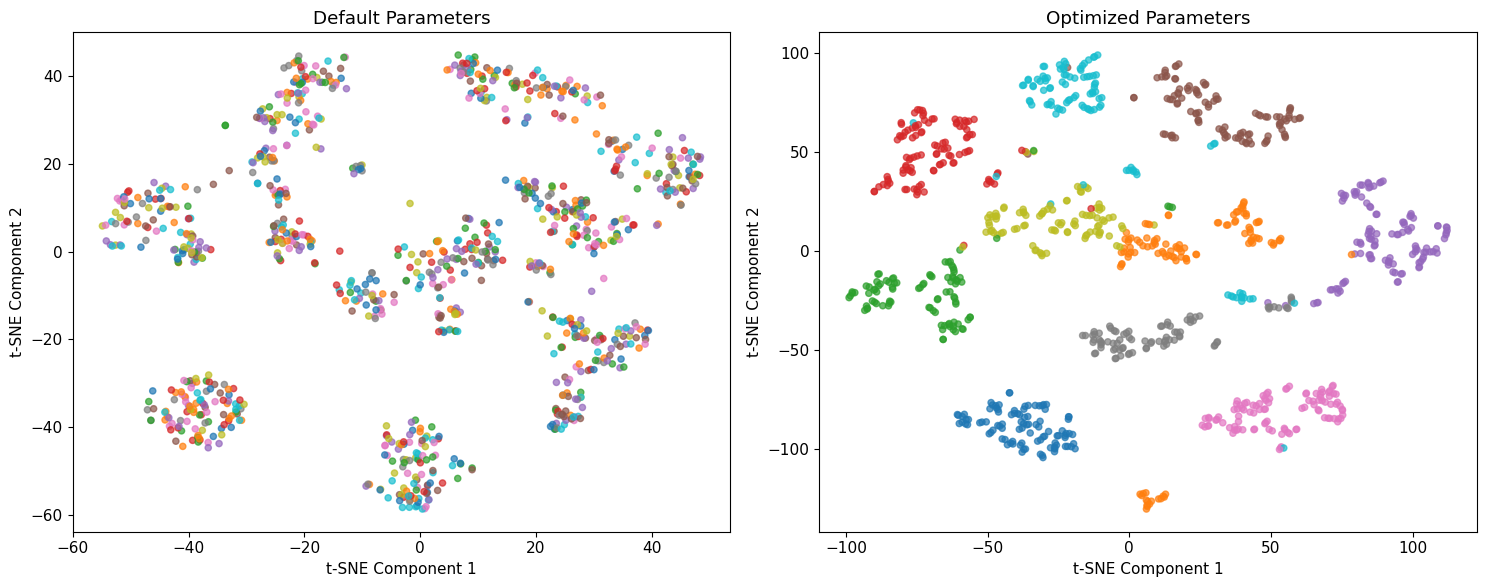

In [7]:
# Example 2: Parameter Optimization and Comparison
print("\n=== EXAMPLE 2: Parameter Optimization ===")

# Use a subset for faster optimization
sample_size = 1000
if len(X_processed) > sample_size:
    idx = np.random.choice(len(X_processed), sample_size, replace=False)
    X_sample, y_sample = X_processed[idx], y[idx]
else:
    X_sample, y_sample = X_processed, y

# Optimize parameters
print("Optimizing t-SNE parameters...")
best_params = pipeline.optimize_parameters(X_sample)

# Compare with optimized parameters
X_embedded_opt = pipeline.fit_transform(X_sample, use_optimized_params=True)
metrics_opt = pipeline.evaluate_quality(X_sample, y_sample)

print("\\nOptimized Results:")
print_evaluation_results(metrics_opt)

# Visualization comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Default parameters
ax1.scatter(X_embedded[:sample_size, 0], X_embedded[:sample_size, 1], c=y_sample, cmap='tab10', alpha=0.7, s=20)
ax1.set_title('Default Parameters')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')

# Optimized parameters
ax2.scatter(X_embedded_opt[:, 0], X_embedded_opt[:, 1], c=y_sample, cmap='tab10', alpha=0.7, s=20)
ax2.set_title('Optimized Parameters')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()